# Magnetic Susceptibility differences and Iron gene expression levels in GTS.

* Objective is to examine association between Striatal Magnetic Susceptibility statistical maps and the expression of iron-related gene-sets. 
<br><br>

* Analysis driven by         
    * **Romme, Biological Psychiatry, 2017:** Connectome Disconnectivity and Cortical Gene Expression in Patients With Schizophrenia
    * **Whitaker, PNAS, 2016:** Adolescence is associated with genomically patterned consolidation of the hubs of the human brain connectome.
    * **Wong, Cerebral Cortex, 2017:** Inter-Regional Variations in Gene Expression and Age-Related Cortical Thinning in the Adolescent Brain
    * **Shin, Cerebral Cortex, 2016:** Cell-Specific Gene-Expression Profiles and Cortical Thickness in the Human Brain
    * **Romero-Garcia, OHBM, 2017:** Gene expression analysis of structural cortical differences in autism
    * **Richiardi, Science, 2015:** Correlated gene expression supports synchronous activity in brain networks




In [24]:
%matplotlib inline
import os
import math 
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn.decomposition import TruncatedSVD, PCA
from matplotlib.colors import rgb2hex
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999

sns.set_style('white')
ahba_dir     = '/scr/malta3/workspace/project_iron/AHBA'
ahba_dir     = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/SEPT10/AHBA/'
save_fig_dir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v3'

drop_strings = ['coords_native', 'donor_names', 'struct_id', 
                'struct_name', 'top_struct', 'Mean', 'Median', 
                'PC1', 'PC2','PC3', #'SVD1g', 'SVD2g','SVD3g', 'SVD3p', 'SVD2p','SVD3p', 
                'corrected_mni_x', 'corrected_mni_y', 'corrected_mni_z']

import warnings
warnings.filterwarnings('ignore')

# quality control
# drop wells outside the striatal masks 
drop_wells = [2371, 13913, 2379, 127687508]
drop_wells = [2371, 2379, 159226045, 160091500] 
#drop_wells = [2977,13913,13786]  


# Lets be colour-full 

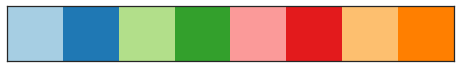

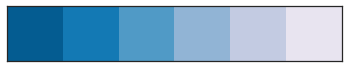

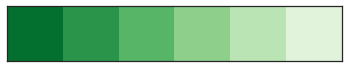

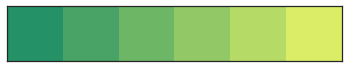

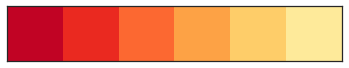

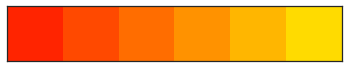

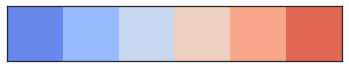

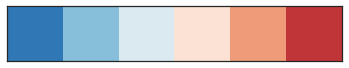

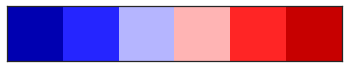

In [25]:
# colours
P = sns.color_palette("Paired",8)
B = sns.color_palette("PuBu_r")
G = sns.color_palette("Greens_r")
R = sns.color_palette("YlOrRd_r")
S = sns.color_palette("summer")
A = sns.color_palette("autumn")
C = sns.color_palette("coolwarm")
D = sns.color_palette("RdBu_r")

sns.palplot(P)
sns.palplot(B)
sns.palplot(G)
sns.palplot(S)
sns.palplot(R)
sns.palplot(A)
sns.palplot(C)
sns.palplot(D)
sns.palplot(sns.color_palette("seismic"))

# Geneset contents

In [26]:
##################################################################################################
# Genesets 
##################################################################################################

GS_IRON_H   = ['FTH1','FTL' ,'HFE','HFE2','IL1A', 'IL6', 'IL6R','IREB2','SLC40A1','TF','TFR2','TNF',]
GS_IRON_D = ['THRSP', 'TF', 'MAL', 'KLK6', 'HOMER1', 'MOBP', 'APOD', 'MOG', 'CRYAB', 'APOC1', 'CA2', 'RASGRP1', 
          'STMN4', 'LYZ','GSTM1', 'CTSS',  'DCK' ]

GS_IRON_IH = ['ABCB6', 'ABCB7', 'ABCG2', 'ACO1', 'ALAS2', 'BMP6', 'CP', 'CYBRD1',  'FLVCR1', 'FTH1',  'FTHL17',
                        'FTL', 'FTMT', 'FXN', 'GDF2', 'HAMP', 'HEPH', 'HFE', 'HFE2', 'HIF1A', 'HMOX1', 'HMOX2', 'HPX', 'IREB2', 'ISCU', 'LCN2',
                        'LTF', 'MYC', 'NDFIP1', 'NUBP1', 'SCARA5', 'SLC11A1', 'SLC11A2', 'SLC22A17', 'SLC40A1', 'SLC46A1', 'SMAD4', 'SOD1',
                        'SRI', 'TF', 'TFR2', 'TFRC', 'TMPRSS6', 'TTC7A']

GS_IRON_IM = ['HFE', 'MFI2', 'PICALM', 'SLC11A2', 'STEAP1', 'STEAP1B', 'STEAP2', 'STEAP3', 'STEAP4', 'TF', 
              'TFR2', 'TFRC']

GS_IRON_T1 = ['ABCB6', 'ABCB7', 'ABCG2', 'FLVCR1', 'FLVCR2', 'HPX', 'HRG', 'LCN2',
                   'SLC22A17', 'SLC46A1', 'SLC48A1']
GS_IRON_T2 = ['ABCG2', 'ATP6V0A2', 'ATP6V0A4', 'ATP6V0B', 'ATP6V0C', 'ATP6V0D1', 'ATP6V0D2', 'ATP6V0E1', 'ATP6V1A',
              'ATP6V1B1', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1C2', 'ATP6V1D', 'ATP6V1E1', 'ATP6V1E2', 'ATP6V1F', 'ATP6V1G1',
              'ATP6V1G2', 'ATP6V1G3', 'ATP6V1H', 'CP', 'CYBRD1', 'FLVCR1', 'FTH1', 'FTL', 'HEPH', 'HMOX1', 'HMOX2',
              'MCOLN1', 'SLC40A1', 'SLC46A1', 'STEAP3', 'TCIRG1', 'TF', 'TFRC']

GS_IRON_R = ['ABAT', 'ABCG2', 'ACO1', 'ALAD', 'APBB1', 'ATP7A', 'B2M', 'BCL2', 'BMP6', 'C1QA', 'CCNB1', 'CCND1',
             'CPOX', 'CYBRD1', 'CYP1A1', 'DRD2', 'FXN', 'GSK3B', 'HAMP', 'HFE', 'HMOX1', 'LCT', 'MDM2', 'PAWR',
             'PDX1', 'SLC11A2', 'SLC40A1', 'SLC6A3', 'SNCA', 'TF', 'TFAP2A', 'TFF1', 'TFR2', 'TFRC', 'UROD']



GS_DA     = ['COMT', 'DDC', 'MAOA', 'MAOB', 'NQO1', 'PPP2CA', 'PPP2CB', 'PRKACA', 'PRKACB','PRKACG', 'TH', 'TYR']
GS_DA_receptor_bind = ['GNA13', 'DLG4', 'DNM1', 'DNM2','DRD1', 'DRD3','GNA12','GNAS',  'ARRB2', 'ATP1A3', 'PALM', 
                    'CLIC6', 'PTPN11', 'PPP1R1B', 'DNAJC14', 'CAV2', 'SLC9A3R1']
GS_DA_receptor_sig  = ['ADCY5', 'ADCY6', 'ARRB2', 'CALY','DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'FLNA', 
                   'GNA11', 'GNA14', 'GNA15', 'GNAI3', 'GNAL', 'GNAO1', 'GNAQ', 'GNAS', 'GNB1', 'GNG2', 
                   'GPR21', 'GPR52', 'GSK3A', 'GSK3B', 'HMP19', 'KLF16', 'OPRM1', 'RGS9', 'SLC9A3R1']
GS_DA_transport     = ['CHRM5','DRD1','PARK2','PARK7','SLC18A2','SLC22A1','SLC22A2','SLC22A3', 'SLC6A2',
                    'SLC6A3','SNCA']
GS_DA_transmission  = ['CDK5','CRH','CRHBP','DRD1','DRD2','DRD3','DRD4','DRD5','RASD2','TH']
GS_ANMC = ['ME1', 'ALDH5A1', 'GBE1', 'GALM', 'PYGL', 'CPS1','PFKFB3', 'PYGB', 'IDH2', 'ENO1','PPP1R1A', 
        'MDH2', 'CS','PYGM', 'PGM3', 'PHKG1', 'SLC3A2', 'PFKFB4', 'KHK','LDHB', 'PCK2','SLC2A8',  'PGM2', 
        'GPT','AKR1B1', 'NANS', 'PDK4','OGDHL','DHTKD1', 'PFKM', 'PGM1', 'PC','AGL']
GS_GLU  = ['UNC13B', 'RIMS1', 'GLS2', 'GLS', 'SLC38A2', 'SLC17A7', 'RAB3A', 'SLC1A1', 'SLC1A6', 'SLC1A7', 
        'SNAP25', 'STX1A', 'STXBP1','VAMP2', 'SYT1' ]
GS_GABA = ['GPHN', 'GABARAP','DNM1', 'GABRA1', 'GABRA2', 'GABRA3', 'GABRA4','GABRA5','GABRA6''SRC'] 
GS_GABA_GLU = GS_GLU + GS_GABA
GS_TF       = ['TF']
GS_FTH      = ['FTH1']
GS_FTL      = ['FTL']
GS_HRE      = ['HFE']
GS_HRE2     = ['HFE2']
GS_SLC25    = ['SLC25A37']
GS_SLC40    = ['SLC40A1']
GS_BIOBANK  = GS_TF + GS_FTH + GS_HRE + GS_SLC25
GS_FTH_ALL  = ['FTH1', 'FTH1P14', 'FTH1P20', 'FTHL17' ]
GS_FTL_ALL  = ['FTL', 'FTLP17']
GS_FERRITIN = GS_FTH_ALL + GS_FTL_ALL + ['FTMT']

GS_TCA = ['ACLY', 'ACO1', 'ACO2', 'CS', 'DLAT', 'DLD', 'DLST', 'FH', 'IDH1', 'IDH2', 'IDH3A', 'IDH3B',
      'IDH3G', 'LOC283398', 'LOC642502', 'MDH1', 'MDH2', 'OGDH', 'OGDHL', 'PC',  'PCK1',  'PCK2',
     'PDHA1', 'PDHA2', 'PDHB', 'SDHA', 'SDHB', 'SDHC', 'SDHD', 'SUCLA2', 'SUCLG1', 'SUCLG2']

GS_BTBD9 = ['BTBD9']
GS_ACO1 = ['ACO1']
GS_ACO2 = ['ACO2']
GS_ACO =  GS_ACO1+ GS_ACO2


# Read Geneset Expression Values
* Each dataframe contrains expression values from each sampling well, total wells = 3702 
* Each Well corresponds to an MNI coordinate
* For each gene, expression was calculate as the average of all probes
* 5 principal components were also extracted for each geneset of interest (IRON,IRON_D,ANMC)

In [27]:
def return_expression_df(geneset):
    return pd.read_csv(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset),index_col=0)

IRON_H           = return_expression_df('IRON_HOMEOSTASIS_PCA')
IRON_D           = return_expression_df('IRON_D_PCA')
IRON_IH          = return_expression_df('IRON_ION_HOMEOSTASIS_PCA')
IRON_IM          = return_expression_df('IRON_ION_IMPORT_PCA')
IRON_IB          = return_expression_df('IRON_ION_BINDING_PCA')
IRON_T1          = return_expression_df('IRON_TRANSPORT1_PCA')
IRON_T2          = return_expression_df('IRON_TRANSPORT2_PCA')
IRON_R           = return_expression_df('IRON_RESPONSE_PCA')
ANMC             = return_expression_df('ANMC_PCA')
DA_met           = return_expression_df('DA_metabolism_PCA')
DA_receptor_sig  = return_expression_df('DA_receptor_sig_PCA')
DA_receptor_bind = return_expression_df('DA_receptor_PCA')
DA_transmission  = return_expression_df('DA_tranmission_PCA')
DA_transport     = return_expression_df('DA_transport_PCA')
ANMC             = return_expression_df('ANMC_PCA')
GLU              = return_expression_df('GLU_PCA')
GABA             = return_expression_df('GABA_PCA')
GLU_GABA         = return_expression_df('GLU_GABA_PCA')
FTH_ALL          = return_expression_df('FTH_ALL_PCA')
FERRITIN         = return_expression_df('FERRITIN_PCA')
FTL_ALL          = return_expression_df('FTL_ALL')
TF               = return_expression_df('TF')
FTH              = return_expression_df('FTH')
FTL              = return_expression_df('FTL')
HRE              = return_expression_df('HFE')
HRE2             = return_expression_df('HFE2')
SLC25            = return_expression_df('SLC25')
BIOBANK          = return_expression_df('BIOBANK_PCA')
BTBD9            = return_expression_df('BTBD9') 
TCA              = return_expression_df('TCA_PCA') 
ACO              = return_expression_df('ACO') 
ACO1             = return_expression_df('ACO1') 
ACO2             = return_expression_df('ACO2') 
HOUSEKEEPING     = return_expression_df('HOUSEKEEPING') 
HOUSEKEEPING_E   = return_expression_df('HOUSEKEEPING_EISENBERG') 
DA_allen         = return_expression_df('DA_allen_PCA')
DAT1             = return_expression_df('DAT1')
DRD1             = return_expression_df('DRD1')
DRD2             = return_expression_df('DRD2')
DRD3             = return_expression_df('DRD3')
DRD4             = return_expression_df('DRD4')
DRD_ALL          = return_expression_df('DRD_ALL_PCA')


IDH              = return_expression_df('IDH')
IDH1             = return_expression_df('IDH1')
IDH2             = return_expression_df('IDH2')
IDH3             = return_expression_df('IDH3')
IDH3A            = return_expression_df('IDH3A')
IDH3B            = return_expression_df('IDH3B')
IDH3G            = return_expression_df('IDH3G')
GLUD             = return_expression_df('GLUD')
GLUD1            = return_expression_df('GLUD1')
GLUD2            = return_expression_df('GLUD2')
GAD1             = return_expression_df('GAD1')
GAD2             = return_expression_df('GAD2')
MAO              = return_expression_df('MAO')
MAOA             = return_expression_df('MAOA')
MAOB             = return_expression_df('MAOB')
TH               = return_expression_df('TH')

# Read QSM statistical map (represents susceptibility [iron] differences)
* The statistical maps represents susceptibility differences between Healthy controls (N=26) and GTS patients (N=23).
* Maps were calculated with a two sample t-test using 10,000 permutations,threshold- free cluster enhancement, and FWE correction.
* ROIs include L/R_Caud, L/R_Putamen, L/R_Pallidum, STR3_MOTOR, STR3_EXEC, STR3_LIMBIC

In [28]:
#df_MNI10 = pd.read_csv(os.path.join(ahba_dir,'QSM_TSTATS/MNI_NIFTI_VALUES_permute_10K_SEPT10.csv'), index_col = 0 )
#df_MNI = pd.read_csv(os.path.join(ahba_dir,'QSM_TSTATS/MNI_NIFTI_VALUES_permute_10K_SEPT22.csv'), index_col = 0 )
df_MNI = pd.read_csv(os.path.join(ahba_dir,'QSM_TSTATS/MNI_NIFTI_VALUES_permute_10K_OCT2.csv'), index_col = 0 )

# Concatenate Dataframes

In [29]:
def concat_dfs(measure):
    df  = pd.DataFrame(index = IRON_H.index, 
                        columns = ['IRON', 'IRON_D', 'DA_met', 'DA_receptor_bind', 'DA_receptor_sig', 
                                   'DA_transmission', 'DA_transport', 'ANMC', 'GLU', 'GABA', 'GLU_GABA', 
                                   'TF', 'FTH', 'FTL', 'HRE', 'HRE2', 'SLC25', 'SLC40', 'BIOBANK',
                                   'BTBD9', 'TCA', 'ACO','ACO1', 'ACO2', 'HOUSEKEEPING', 'HOUSEKEEPING_E',
                                   'top_struct', 'struct'])
    xval = 1
    df['top_struct']        = IRON_H.top_struct
    df['struct']            = IRON_H.struct_name
    df['IRON_H']            = IRON_H[measure] * xval
    df['IRON_D']            = IRON_D[measure]
    df['IRON_IH']           = IRON_IH[measure] * xval
    df['IRON_IM']           = IRON_IM[measure] * xval
    df['IRON_IB']           = IRON_IB[measure] * xval
    df['IRON_T1']           = IRON_T1[measure] * xval
    df['IRON_T2']           = IRON_T2[measure] * xval
    df['IRON_R']            = IRON_R[measure] * xval
    df['DA_met']            = DA_met[measure] * xval
    df['DA_receptor_bind']  = DA_receptor_bind[measure] * xval
    df['DA_receptor_sig']   = DA_receptor_sig[measure] * xval
    df['DA_transmission']   = DA_transmission[measure] * xval
    df['DA_transport']      = DA_transport[measure] * xval
    df['ANMC']              = ANMC[measure] * xval
    df['GLU']               = GLU[measure] * xval
    df['GABA']              = GABA[measure] * xval
    df['GLU_GABA']          = GLU_GABA[measure] * xval
    df['FTH_ALL']           = FTH_ALL[measure] * xval    
    df['FERRITIN']          = FERRITIN[measure] * xval    
    df['TCA']               = TCA[measure] * xval
    df['DA_allen']          = DA_allen[measure] * xval
    df['DRD_ALL']           = DRD_ALL[measure] * xval
    
    if measure not in ['PC1', 'PC2', 'PC3', 'SVD1g','SVD2g', 'SVD3p', 'SVD1p','SVD2p', 'SVD3p']: 
        df['FTL_ALL']           = FTL_ALL[measure] * xval    
        df['TF']                = TF['TF'] * xval
        df['FTH']               = FTH['FTH1'] * xval
        df['FTH1P14']           = FERRITIN['FTH1P14'] * xval    
        df['FTH1P20']           = FERRITIN['FTH1P20'] * xval    
        df['FTHL17']            = FERRITIN['FTHL17'] * xval    
        df['FTL']               = FTL['FTL'] * xval
        df['HFE']               = HRE['HFE'] * xval
        df['HFE2']              = HRE2['HFE2'] * xval
        df['SLC25']             = SLC25['SLC25A37'] * xval
        df['BTBD9']             = BTBD9['BTBD9'] * xval
        df['ACO']               = ACO[measure] * xval
        df['ACO1']              = ACO1['ACO1'] * xval
        df['ACO2']              = ACO2['ACO2'] * xval
        df['BIOBANK']           = BIOBANK[measure] * xval
        df['HOUSEKEEPING']      = HOUSEKEEPING[measure] * xval
        df['HOUSEKEEPING_E']    = HOUSEKEEPING_E[measure] * xval
        df['DAT1']              = DAT1['SLC6A3'] * xval
        df['DRD1']              = DRD1['DRD1'] * xval
        df['DRD2']              = DRD2['DRD2'] * xval
        df['DRD3']              = DRD3['DRD3'] * xval
        df['DRD4']              = DRD4['DRD4'] * xval
        df['IDH']               = IDH[measure] * xval
        df['IDH1']              = IDH1['IDH1'] * xval
        df['IDH2']              = IDH2['IDH2'] * xval
        df['IDH3']              = IDH3[measure] * xval
        df['IDH3A']             = IDH3A['IDH3A'] * xval
        df['IDH3B']             = IDH3B['IDH3B'] * xval
        df['IDH3G']             = IDH3G['IDH3G'] * xval
        df['GLUD']              = GLUD[measure] * xval
        df['GLUD1']             = GLUD1['GLUD1'] * xval
        df['GLUD2']             = GLUD2['GLUD2'] * xval
        df['GAD1']              = GAD1['GAD1'] * xval
        df['GAD2']              = GAD2['GAD2'] * xval
        df['MAOA']              = MAOA['MAOA'] * xval
        df['MAOB']              = MAOB['MAOB'] * xval
        df['MAO']               = MAO[measure] * xval
        df['TH']                = TH['TH'] * xval
    dfc = pd.concat([df_MNI, df], axis = 1)
    return dfc

df_SVD1g  = concat_dfs('SVD1g')
df_SVD2g  = concat_dfs('SVD2g')
df_SVD1p  = concat_dfs('SVD1p')
df_SVD2p  = concat_dfs('SVD2p')
#df_SVD3  = concat_dfs('SVD3')
df_PC1   = concat_dfs('PC1')
df_PC2   = concat_dfs('PC2')
df_PC3   = concat_dfs('PC3')
df_MU    = concat_dfs('Mean')

# Fixed Effect Correlations

In [30]:
rois = ['Caud',
        'Puta',
        'STR3_MOTOR', 
        'STR3_EXEC', 
        'STR3_LIMBIC', 
       ]

def detect_outlier_subjects(df,measure,m=2):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])
    outliers = []
    for subject in df.index:
        if df.loc[subject][measure] > upper:
            outliers.append(subject) 
        elif df.loc[subject][measure] < lower:
            outliers.append(subject) 
    #print outliers,measure
    return outliers

def make_corr(DF, met1,met2, color, annotate=0, scatter=1, ci = 95, lstyle='-', lw=3, fname='pc'):
    DF = DF
    dfx = pd.DataFrame(index=DF.index)
    dfx[met1]  = DF[met1]  #* 10
    dfx[met2]  = DF[met2]
    
    dfx = dfx.drop(drop_wells ,axis=0).dropna()
    #dfx = dfx.drop([159226077, 127687121],axis=0).dropna()
    r_val = np.round(pearsonr(dfx[met1], dfx[met2])[0],2)
    p_val = np.round(pearsonr(dfx[met1], dfx[met2])[1],10)
    #print len(dfx), r_val, p_val
    
    if p_val < 1:
        print met1, met2[0:6], r_val, p_val
        grid = sns.JointGrid(met1, met2, data=dfx)#,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
        grid.plot_marginals(sns.distplot, color = color, hist=0, kde = 1, kde_kws={'shade':1})
                            #rug = 1, rug_kws = {'height':0.1})  
        grid.plot_joint(sns.regplot, fit_reg=1, scatter= scatter, color = color, ci = ci,
                       line_kws={'linestyle': lstyle, 'lw':lw}) 
                    #line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
        #sns.jointplot(met1, met2,dfx, kind = 'reg', color=color)
        #plt.vlines(0,5,7.5)
        #plt.set_axis_labels()
        #if annotate:
        #    plt.annotate('R=%s, P=%s' %(r_val, p_val), xy = annotate, fontsize = 13,  color='r')
        #plt.xlabel('')
        #plt.ylabel('')
        plt.xticks(fontsize=12, weight='bold')
        plt.yticks(fontsize=12, weight='bold')
        #plt.ylim(-.5,1.5)
        #plt.xlim(-30,50)
        plt.savefig(os.path.join(save_fig_dir, 'corr_%s_%s_%s.png' %(met1,met2,fname)), dpi = 300,
                    bbox_inches='tight', transparent = True)

    return dfx


In [31]:
#detect_outlier_subjects(df_PC1,'STR3_MOTOR_tstat_CP_1mm',m=2)

### Geneset-PC1 vs Striatal-Motor Suscspibility reductions 

tstat
IRON_H STR3_M 0.42 0.0009798543
IRON_D STR3_M 0.4 0.0016283418
IRON_T2 STR3_M 0.45 0.0003328754
FERRITIN STR3_M 0.6 7.276e-07
IRON_IM STR3_M 0.31 0.0198981182
IRON_R STR3_M 0.36 0.0053703488


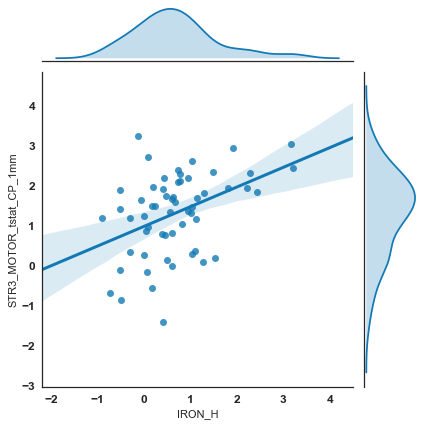

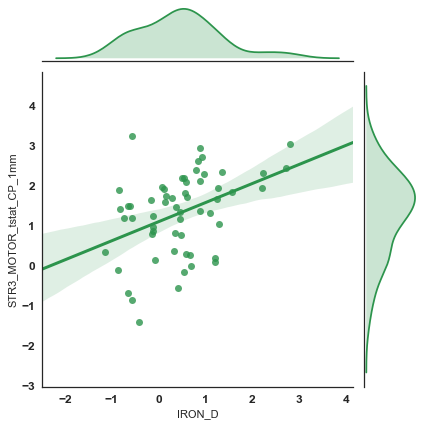

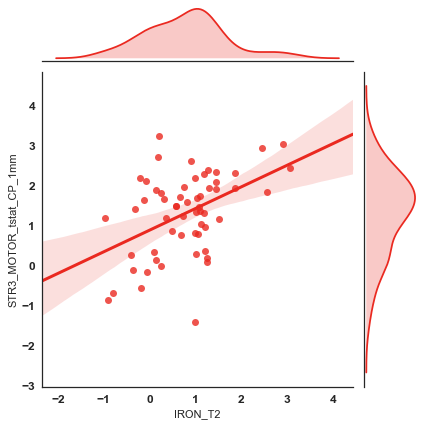

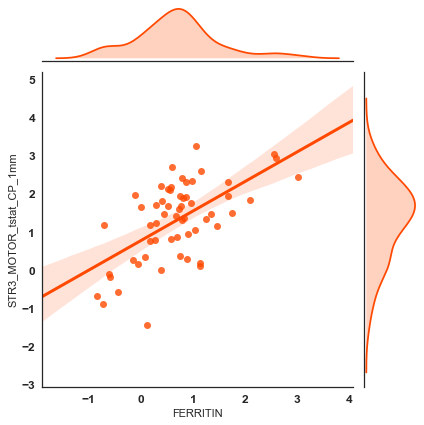

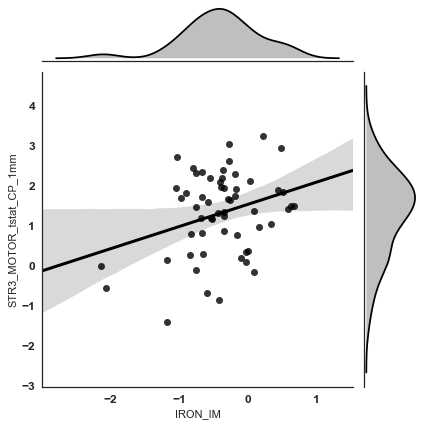

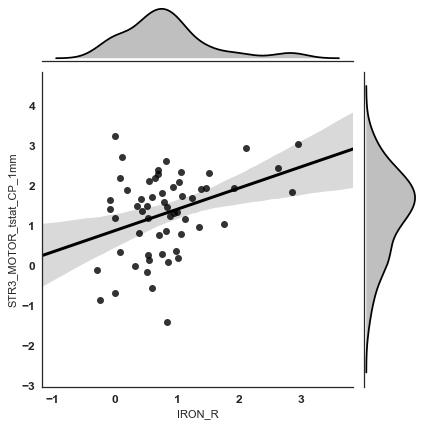

In [33]:
print 'tstat'
df = df_PC1
fname = 'pc'
for roi in ['STR3_MOTOR_tstat_CP_1mm']:
    dfx_iron_h  = make_corr(df,'IRON_H',  roi, B[1], (0.14,1.4), fname=fname)
    dfx_iron_d  = make_corr(df,'IRON_D',  roi, G[1], (0.14,1.4), fname=fname)
    dfx_iron_t2 = make_corr(df,'IRON_T2', roi, R[1], (65,1.4),   fname=fname)
    dfx_ferr    = make_corr(df,'FERRITIN',roi, A[1], (65,1.4),   fname=fname)
    #dfx_iron_t1 = make_corr(df,'IRON_T1', roi, 'k', (65,1.4),   fname=fname)
    dfx_iron_im = make_corr(df,'IRON_IM', roi, 'k', (65,1.4),   fname=fname)
    dfx_iron_r  = make_corr(df,'IRON_R',  roi, 'k', (65,1.4),   fname=fname)


tstat
IRON_H STR3_E 0.09 0.5179249451
IRON_D STR3_E 0.3 0.0287751387
IRON_T2 STR3_E -0.06 0.6719112349
FERRITIN STR3_E 0.04 0.7772065928
IRON_T1 STR3_E 0.01 0.944696543
IRON_IM STR3_E -0.06 0.6558657237
IRON_R STR3_E -0.1 0.4757347141


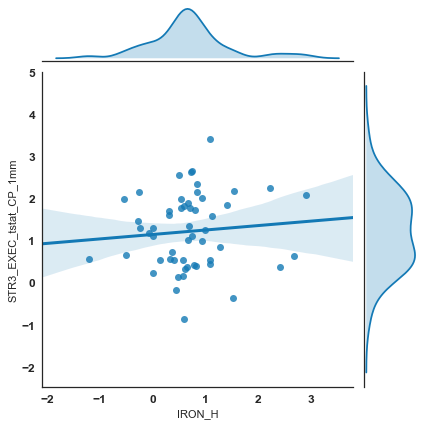

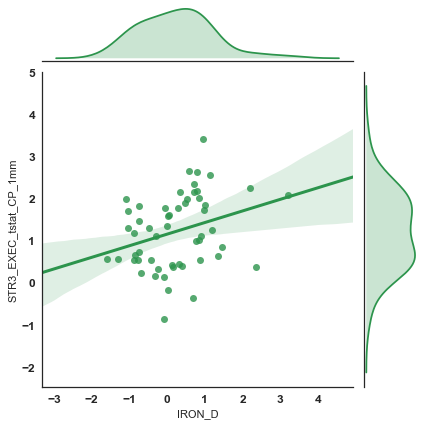

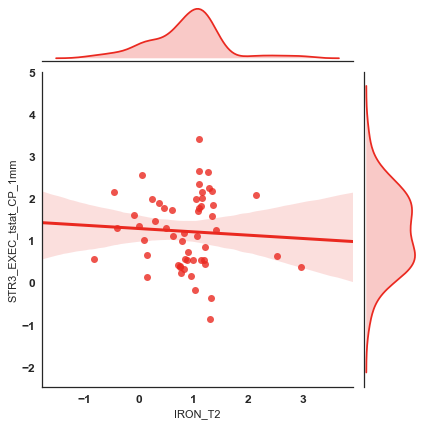

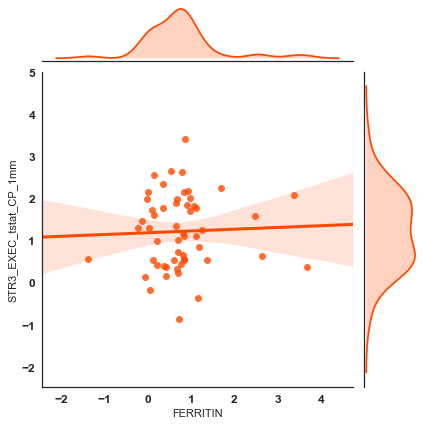

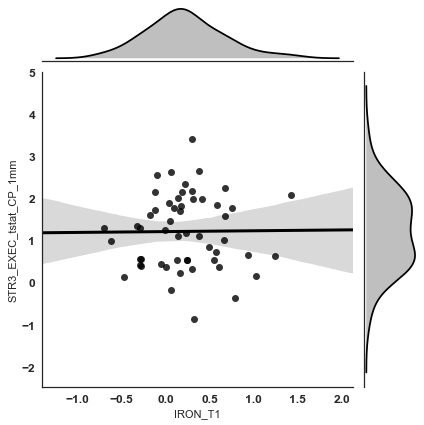

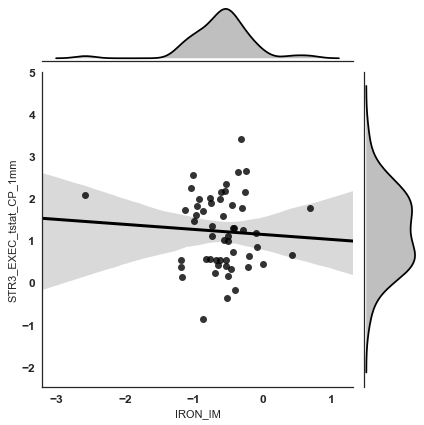

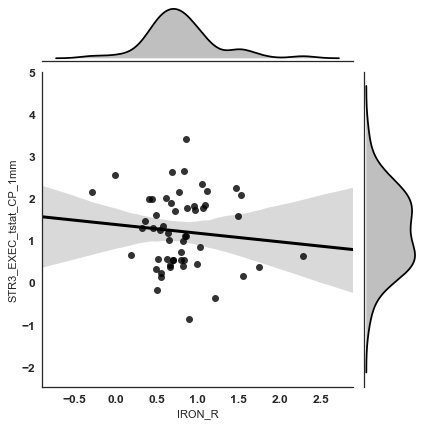

In [34]:
print 'tstat'
df = df_PC1
fname = 'pc'
for roi in ['STR3_EXEC_tstat_CP_1mm']:
    dfx_iron_h  = make_corr(df,'IRON_H',  roi, B[1], (0.14,1.4), fname=fname)
    dfx_iron_d  = make_corr(df,'IRON_D',  roi, G[1], (0.14,1.4), fname=fname)
    dfx_iron_t2 = make_corr(df,'IRON_T2', roi, R[1], (65,1.4),   fname=fname)
    dfx_ferr    = make_corr(df,'FERRITIN',roi, A[1], (65,1.4),   fname=fname)
    dfx_iron_t1 = make_corr(df,'IRON_T1', roi, 'k', (65,1.4),   fname=fname)
    dfx_iron_im = make_corr(df,'IRON_IM', roi, 'k', (65,1.4),   fname=fname)
    dfx_iron_r  = make_corr(df,'IRON_R',  roi, 'k', (65,1.4),   fname=fname)


tstat
IRON_H STR3_M 0.27 0.0369281428
IRON_D STR3_M 0.44 0.0004818917
IRON_T2 STR3_M 0.41 0.0012908949
FERRITIN STR3_M 0.54 1.16467e-05
IRON_T1 STR3_M 0.36 0.0059358137
IRON_IM STR3_M 0.28 0.0314621089
IRON_R STR3_M 0.51 5.08501e-05


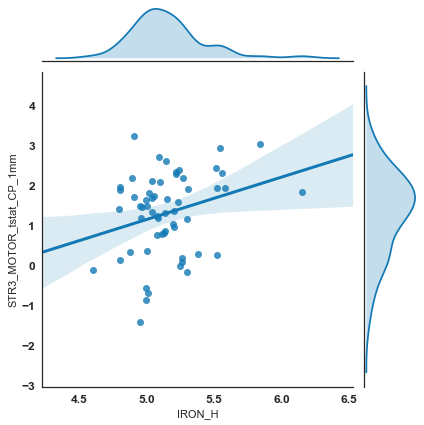

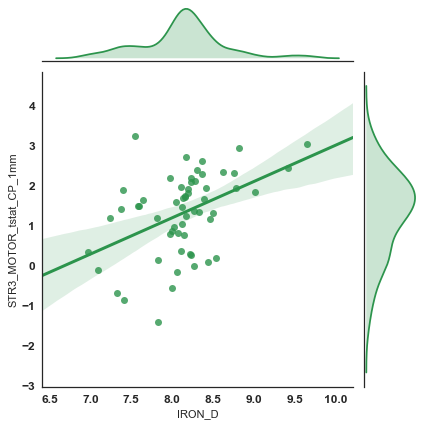

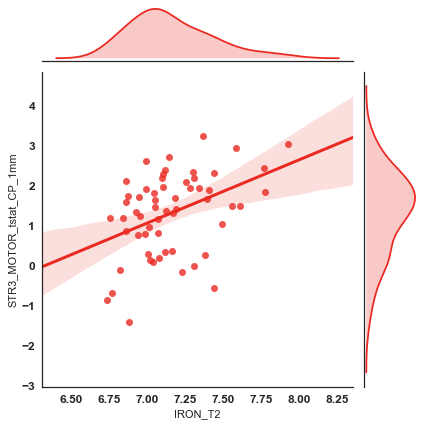

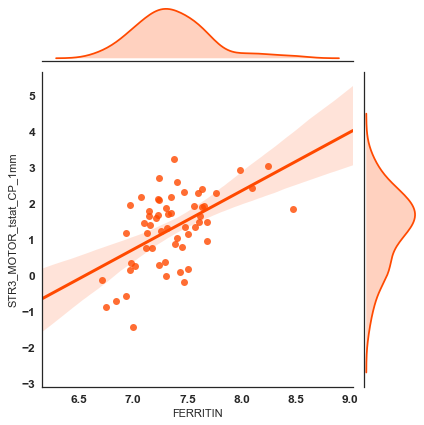

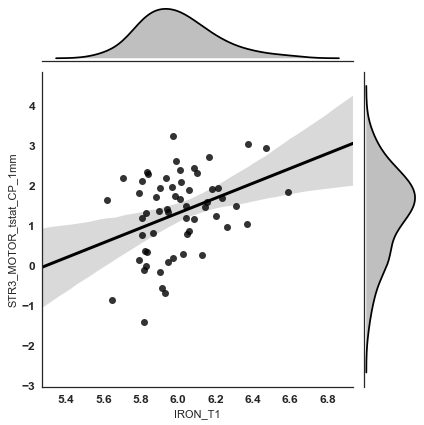

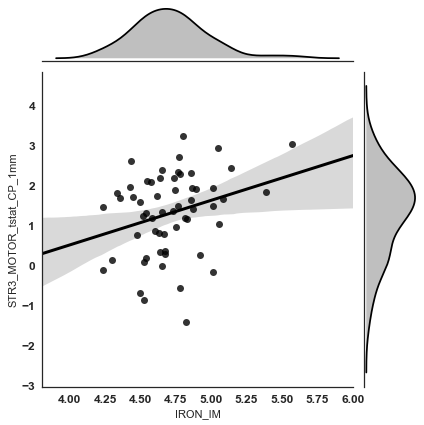

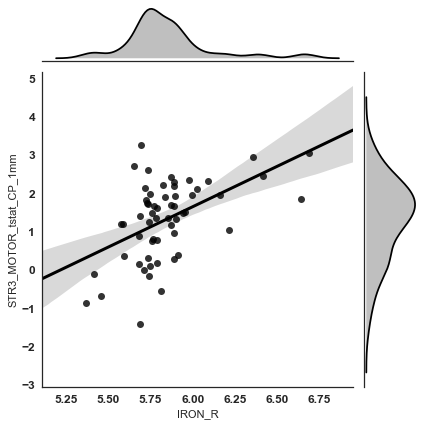

In [35]:
print 'tstat'
df = df_MU
fname = 'mean'
for roi in ['STR3_MOTOR_tstat_CP_1mm']:
    dfx_iron_h  = make_corr(df,'IRON_H',  roi, B[1], (0.14,1.4), fname=fname)
    dfx_iron_d  = make_corr(df,'IRON_D',  roi, G[1], (0.14,1.4), fname=fname)
    dfx_iron_t2 = make_corr(df,'IRON_T2', roi, R[1], (65,1.4),   fname=fname)
    dfx_ferr    = make_corr(df,'FERRITIN',roi, A[1], (65,1.4),   fname=fname)
    dfx_iron_t1 = make_corr(df,'IRON_T1', roi, 'k', (65,1.4),   fname=fname)
    dfx_iron_im = make_corr(df,'IRON_IM', roi, 'k', (65,1.4),   fname=fname)
    dfx_iron_r  = make_corr(df,'IRON_R',  roi, 'k', (65,1.4),   fname=fname)


# Inspect PCA Loadings 

In [41]:
from math import pi
import matplotlib.pyplot as plt

def plot_loadings(gset, C, sorter='PC1', save = 0, ticks = 1, labelsize=25, frac=1.1):
    # Set data
    if sorter != 'PC1':
        sorter = sorter
    loadings = pd.read_csv(os.path.join(ahba_dir,'loadings_%s.csv'%gset), 
                           index_col=0).sort_values(sorter, ascending=0)

    loading_index = [i for i in loadings.index]
    cat = loading_index
    values = list(loadings['PC1']) # [90, 60, 65, 70, 40]
    values2 = list(loadings['PC2']) # [90, 60, 65, 70, 40]
    values3 = list(loadings['PC3']) # [90, 60, 65, 70, 40]
    #values4 = list(loadings.PC4) # [90, 60, 65, 70, 40]

    N = len(cat)
    x_as = [n / float(N) * 2 * pi for n in range(N)]

    # Because our chart will be circular we need to append a copy of the first 
    # value of each list at the end of each list with data
    values.append(list(loadings['PC1'])[0])
    values = np.abs(np.array(values))

    values2.append(list(loadings['PC2'])[0])
    values2 = np.abs(np.array(values2))

    values3.append(list(loadings['PC3'])[0])
    values3 = np.abs(np.array(values3))


    x_as += x_as[:1]

    # Set color of axes
    plt.rc('axes', linewidth=0.5, edgecolor="#888888")

    # Create polar plot
    fig = plt.figure(figsize=(20,20))
    fig = plt.figure(figsize=(10,10))
    ax  = plt.subplot(111, polar=True)

    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(range(0,len(loading_index)), frac=frac)

    #Set position of y-labels
    ax.set_rlabel_position(0)

    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=1)
    ax.yaxis.grid(True, color="#888888", linestyle='dashed', linewidth=1)##888888

    # Set number of radial axes and remove labels
    myriad = {'fontname':'Myriad Pro'}
    print loading_index
    
    loadings_index2 = []
    for i in loading_index:
        if 'ATP' not in i:
            loadings_index2.append(i) 
        elif 'ATP' in i:
            loadings_index2.append(r'%s$_{\rm %s}$'%(i[0:4],i[4:]) )
    
    if ticks:
        plt.xticks(x_as[:-1], loadings_index2, size = 18, weight='bold')
    else:
        plt.xticks(x_as[:-1], [])

    # Set yticks
    #plt.yticks([0, 0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"])

    alpha =0.75
    ax.fill(x_as, values,  rgb2hex(C[1]), alpha=alpha)
    ax.fill(x_as, values2, rgb2hex(C[3]), alpha=alpha)
    ax.fill(x_as, values3, rgb2hex(C[5]), alpha=alpha)
    #ax.fill(x_as, values4, 'm', alpha=0.5)

    plt.tick_params(axis='y', direction='out', labelsize=15)
    plt.tick_params(axis='x', direction='out', which='major',labelsize=labelsize, pad = 50)
    if save: 
        plt.savefig(os.path.join(save_fig_dir, 'loadings_%s.png'%gset), dpi = 300, bbox_inches='tight', transparent=1)

['FTH1', 'FTL', 'TF', 'IL6R', 'SLC40A1', 'IL6', 'IL1A', 'TNF', 'HFE', 'TFR2', 'HFE2', 'IREB2']


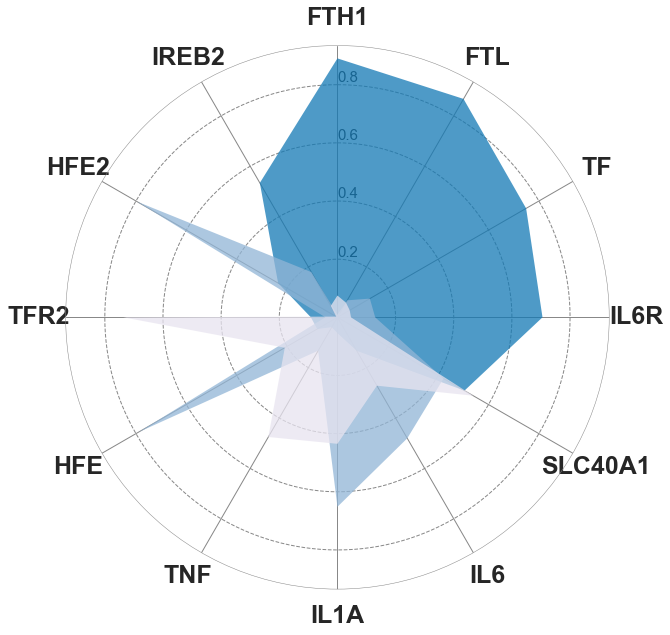

In [42]:
plot_loadings('IRON_HOMEOSTASIS', B )

['MOG', 'TF', 'MOBP', 'MAL', 'KLK6', 'CRYAB', 'APOD', 'CA2', 'STMN4', 'CTSS', 'APOC1', 'DCK', 'LYZ', 'GSTM1', 'THRSP', 'HOMER1', 'RASGRP1']


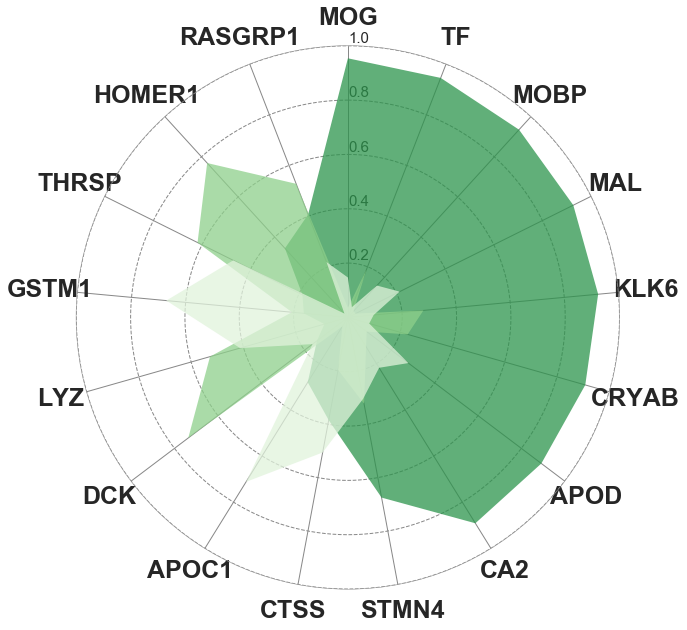

In [43]:
plot_loadings('IRON_D', G)

['FTL', 'CYBRD1', 'HEPH', 'FTH1', 'HMOX1', 'ATP6V0E1', 'TF', 'ABCG2', 'SLC40A1', 'ATP6V0A4', 'TCIRG1', 'ATP6V1E2', 'HMOX2', 'SLC46A1', 'CP', 'ATP6V1D', 'ATP6V0B', 'ATP6V1E1', 'FLVCR1', 'ATP6V1G1', 'ATP6V0A2', 'ATP6V1C2', 'ATP6V1F', 'ATP6V1B2', 'ATP6V0D2', 'ATP6V1G3', 'TFRC', 'ATP6V1H', 'MCOLN1', 'ATP6V0C', 'ATP6V0D1', 'ATP6V1C1', 'STEAP3', 'ATP6V1A', 'ATP6V1B1', 'ATP6V1G2']


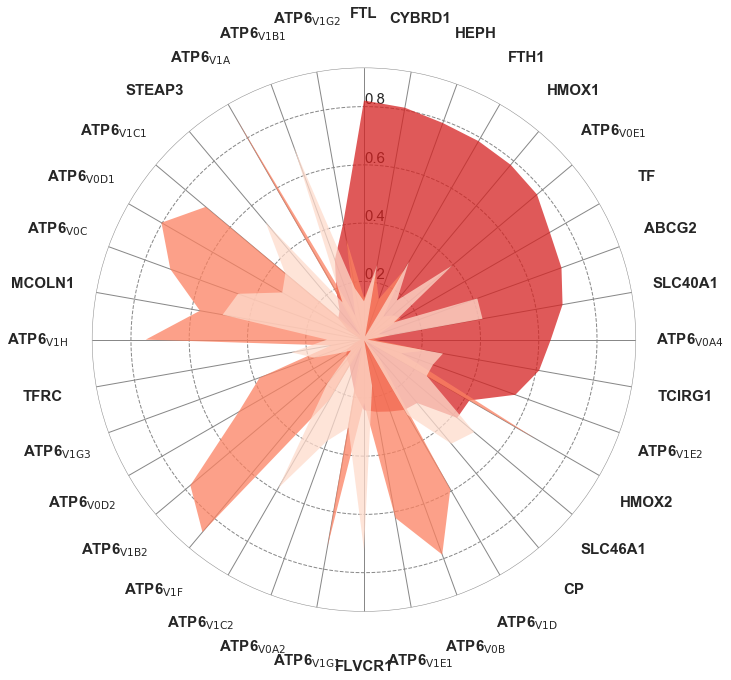

In [44]:
plot_loadings('IRON_TRANSPORT2', sns.color_palette("Reds_r"), frac=1.2, labelsize=15)

['FTH1', 'FTH1P20', 'FTL', 'FTHL17', 'FTH1P14', 'FTMT', 'FTLP17']


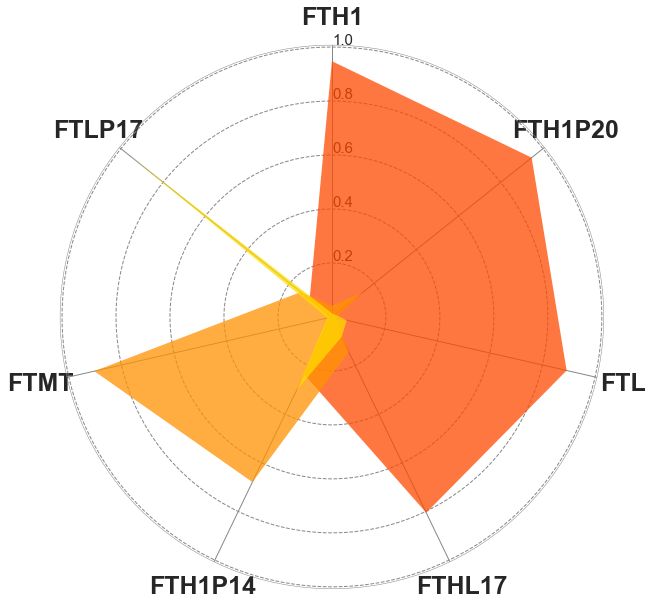

In [45]:
plot_loadings('FERRITIN', A)

# PERMUTATIONS


* To statisticaly evaluate the observed correlations, we examined whether an observed correlation was higher than one could expect under the null-condition.
* The observed correlation for a specific geneset/susceptibilit correlation was tested against a null distribution of correlations.
* 10,000 permutations were used. 
* For each permutation, expression values were extracted from a similar number of genes. 
* The null hypothesis at the 5% FDR-adjusted significance level correcting for multiple testing of X-comparisons. 

# Read expression values of entire AHBA database (still missing many genes)

In [46]:
AHBA = pd.read_csv(os.path.join(ahba_dir, 'ahba_data', 'AHBA_20737.csv'), index_col = 0)
AHBA = AHBA.iloc[:,:-13]

In [47]:
def permute(df_INT, met1, met2, geneset, df_AHBA,  color1, npermutations = 10, save = 1):

    #####################
    ## Get correlation of interest 

    # Concat susceptibility and gene expression columns into new dataframe
    df_int = pd.DataFrame(index = df_INT.index)
    df_int['GEN'] = df_INT[met1]
    df_int['CHI'] = df_INT[met2]
    df_int        = df_int.drop(drop_wells,axis=0).dropna()

    # Pearson Correlation between susceptibility and gene expression
    observed_correlation = np.round(pearsonr(df_int['CHI'], df_int['GEN'])[0],2)
    print 'Observed correlation between Delta-Chi and %s= %s'%(met1, observed_correlation)

    #########################
    ## Run 10,000 permutations 
    
    # Get all gene names in AHBA database (drop contents of geneset and metadata strings)
    #GENES = df_AHBA.drop(drop_strings+geneset, axis = 1).columns
    GENES = df_AHBA.columns
    print 'Total Number of AHBA genes =',len(GENES)
    print 'Geneset of interest contains %s genes' %(len(geneset))

    # Calculate correlation between Susceptibility and a random set of genes (10000 times)
    null_distribution = []
    
    print 'Running %s permutations' %npermutations
    for i in xrange(npermutations):
        GENESET_RAND = random.sample(GENES, len(geneset))

        #create new dataframe with random genes only
        #df_rand      = df_AHBA.drop([gene for gene in geneset if gene in GENES] + 
        #                            [gene for gene in GENES if gene not in GENESET_RAND],axis=1)  
        df_rand      = df_AHBA.drop([gene for gene in GENES if gene not in GENESET_RAND],axis=1)  

        # Calculate mean of the random set of genes and place into dataframe
        df_rand['CHI']  = df_INT[met2]
        df_rand['Mean'] = df_rand[GENESET_RAND].median(axis=1)
        df_rand = df_rand.dropna()
        rv = pearsonr(df_rand['CHI'], df_rand['Mean'])
        #print rv[0]
        null_distribution.append(rv[0])
        
    # Get pval     
    right = np.sum(np.array([np.abs(i) for i in null_distribution if i > observed_correlation]))
    xsum  = np.sum(np.abs(np.array(null_distribution)))
    p_val = right/xsum
    print 'P_val',np.array(p_val)
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    #sns.set(style="white", palette="muted", color_codes=True)
    sns.set_style("white")
    g = sns.distplot(null_distribution, color=color1, hist=1, bins = 30, norm_hist=1, 
                     kde_kws={'linewidth': 2}
                    )

    plt.axvline(np.mean(null_distribution), color=color1, linestyle='-.', linewidth=1)
    plt.axvline(np.percentile(null_distribution, 2.5), color='k', linestyle='-.', linewidth=1)
    plt.axvline(np.percentile(null_distribution, 97.5), color='k', linestyle='-.', linewidth=1)
    plt.axvspan(np.percentile(null_distribution, 2.5),np.percentile(null_distribution, 97.5) , alpha=0.1, color='lightgray')
    plt.axvline(observed_correlation, color='r', linestyle='solid', linewidth=5)
    plt.yticks([0,1,2,3])
    plt.xlim(-.5,.75)
    plt.ylim(0,3.5)
    plt.xticks(fontsize=17, weight='bold')
    plt.yticks(fontsize=17, weight='bold')
    plt.tick_params(axis='x', pad=12)
    plt.tick_params(axis='y', pad=12)
    plt.setp(ax.spines.values(), linewidth=1.5)
    if save:
        plt.savefig(os.path.join(save_fig_dir, 'permute_CHI_%s_%s'%(met1,met2)), dpi = 300, bbox_inches='tight', transparent=1)
    

In [48]:
nperm = 1000

# STR3_MOTOR

1mm_tstat
Observed correlation between Delta-Chi and IRON_H= 0.42
Total Number of AHBA genes = 20737
Geneset of interest contains 12 genes
Running 1000 permutations
P_val 0.0272193747854


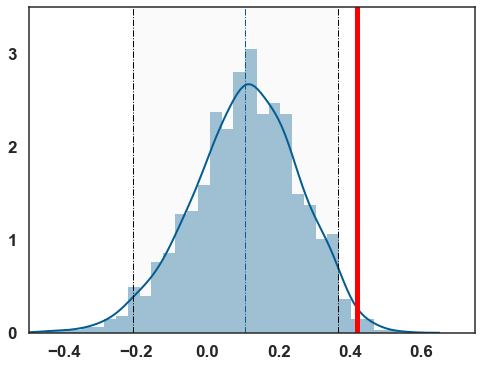

In [54]:
print '1mm_tstat'
permute(df_PC1, 'IRON_H', 'STR3_MOTOR_tstat_CP_1mm',
                 GS_IRON_H, AHBA, color1= B[0]  , npermutations = nperm)

Observed correlation between Delta-Chi and IRON_D= 0.4
Total Number of AHBA genes = 20737
Geneset of interest contains 12 genes
Running 1000 permutations
P_val 0.0515199256729


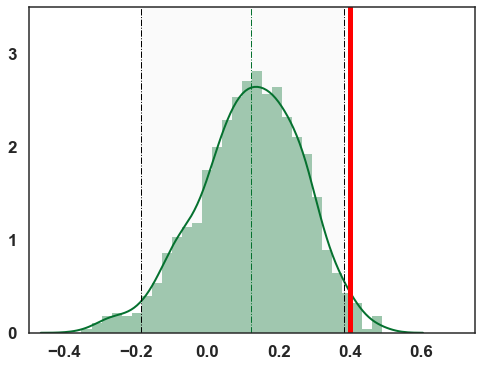

In [50]:
permute(df_PC1, 'IRON_D', 'STR3_MOTOR_tstat_CP_1mm',
                 GS_IRON_H, AHBA, color1= G[0]  , npermutations = nperm)  


Observed correlation between Delta-Chi and IRON_T2= 0.45
Total Number of AHBA genes = 20737
Geneset of interest contains 12 genes
Running 1000 permutations
P_val 0.0154386058939


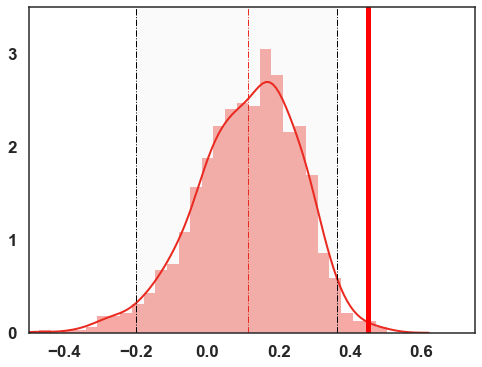

In [51]:
permute(df_PC1, 'IRON_T2', 'STR3_MOTOR_tstat_CP_1mm',
                 GS_IRON_H, AHBA, color1= R[1]  , npermutations = nperm) 

Observed correlation between Delta-Chi and FERRITIN= 0.6
Total Number of AHBA genes = 20737
Geneset of interest contains 12 genes
Running 1000 permutations
P_val 0.0


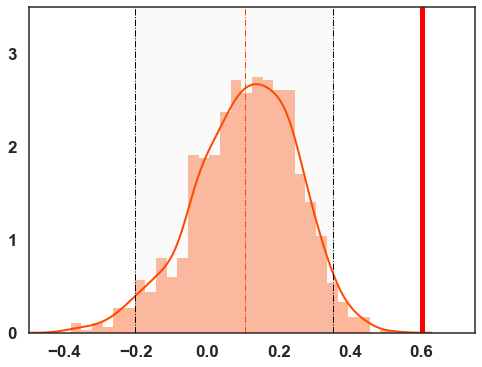

In [52]:
permute(df_PC1, 'FERRITIN', 'STR3_MOTOR_tstat_CP_1mm',
                 GS_IRON_H, AHBA, color1= A[1]  , npermutations = nperm)


# STR3_EXEC

In [ ]:
permute(df_PC1, 'IRON_H', 'STR3_EXEC_tstat_CP_1mm',
                 GS_IRON_H, AHBA, color1= B[0]  , npermutations = nperm)

In [ ]:
permute(df_PC1, 'IRON_D', 'STR3_EXEC_tstat_CP_1mm',
                 GS_IRON_D, AHBA, color1= G[0]  , npermutations = nperm)



In [ ]:
permute(df_PC1, 'IRON_T2', 'STR3_EXEC_tstat_CP_1mm',
                 GS_IRON_T2, AHBA, color1= R[1]  , npermutations = nperm)

In [ ]:
permute(df_PC1, 'FERRITIN', 'STR3_EXEC_tstat_CP_1mm',
                 GS_FERRITIN, AHBA, color1= A[1]  , npermutations = nperm) 

# STR3_LIMBIC

In [ ]:
permute(df_PC1, 'IRON_H', 'STR3_LIMBIC_tstat_CP_1mm',
                 GS_IRON_H, AHBA, color1= B[0]  , npermutations = nperm)

In [ ]:
permute(df_PC1, 'IRON_D', 'STR3_LIMBIC_tstat_CP_1mm',
                 GS_IRON_D, AHBA, color1= G[0]  , npermutations = nperm)

In [ ]:
permute(df_PC1, 'IRON_T2', 'STR3_LIMBIC_tstat_CP_1mm',
                 GS_IRON_T2, AHBA, color1= R[1]  , npermutations = nperm)

In [ ]:
permute(df_PC1, 'FERRITIN', 'STR3_LIMBIC_tstat_CP_1mm',
                 GS_FERRITIN, AHBA, color1= A[1]  , npermutations = nperm)

In [ ]:
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
p_vals  = {'STR3M_IH': 0.0225975450, 'STR3M_ID': 0.039342841929,'STRM_T2': 0.010278541481, 'STR3M_FER': 0.0000,
           'STR3E_IH': 0.2592271924, 'STR3E_ID': 0.039639040211,'STRE_T2': 0.236232936591, 'STR3E_FER': 0.358653489439,
           #'STR3L_IH': 0.2151969008, 'STR3L_ID': 0.431328036659,'STRL_T2': 0.442338644323, 'STR3L_FER': 0.17256221216,
          }

dfs = pd.DataFrame(pd.Series(p_vals), columns = ['pvals']).sort_values('pvals')
dfs['fdr'] = fdrcorrection0(dfs.pvals)[1]
dfs

In [ ]:
# Number of STR coords 
print len(df_PC1.STR3_MOTOR_tstat_CP_1mm.dropna()) #+ \
print len(df_PC1.STR3_EXEC_tstat_CP_1mm.dropna()) #+ \
print len(df_PC1.STR3_LIMBIC_tstat_CP_1mm.dropna())
print len(df_PC1.STR3_MOTOR_tstat_CP_1mm.dropna()) + \
 len(df_PC1.STR3_EXEC_tstat_CP_1mm.dropna()) + len(df_PC1.STR3_LIMBIC_tstat_CP_1mm.dropna()) - len(drop_wells)

In [ ]:
AHBAx = pd.read_csv(os.path.join(ahba_dir, 'ahba_data', 'AHBA_20737.csv'), index_col = 0)

def extract_struct_expression(df, roi, struct):
    structures = set(df[struct].values)
    drop_structs = [i for i in structures if roi not in i]
    df_roi = df[~df[struct].isin(drop_structs)]
    return df_roi

AHBA_CAUD = extract_struct_expression(AHBAx, 'caudate', 'structure_name')#.iloc[:,:-13]
AHBA_PUTA = extract_struct_expression(AHBAx, 'putamen', 'structure_name')#.iloc[:,:-13]
AHBA_PALL = extract_struct_expression(AHBAx, 'pallidus','structure_name')#.iloc[:,:-13]
AHBA_STR  = pd.concat([AHBA_CAUD,AHBA_PUTA])
AHBA_BG   = pd.concat([AHBA_CAUD,AHBA_PUTA, AHBA_PALL])

In [ ]:
print len(AHBA_STR)